<a href="https://colab.research.google.com/github/SamuelBFG/DL-studies/blob/master/Q5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IA353 - Redes Neurais
# EFC3 - Questão 5

## Autoencoder training and manifold visualization
## Partially based on https://www.kaggle.com/apapiu/manifold-learning-and-autoencoders

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):**  Samuel Borges Ferreira Gomes 

### 5.1. Imports

In [2]:
!pip install keras

In [4]:
import tensorflow as tf
import os

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, Input
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical

### 5.2. Reading the data

In [5]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [7]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)


In [8]:
x_images = x_train.reshape(x_train.shape[0], 28, 28)

In [9]:
# Definition of a function to visualize some digits
def show(img):
    plt.imshow(img, cmap = "gray", interpolation = "none")

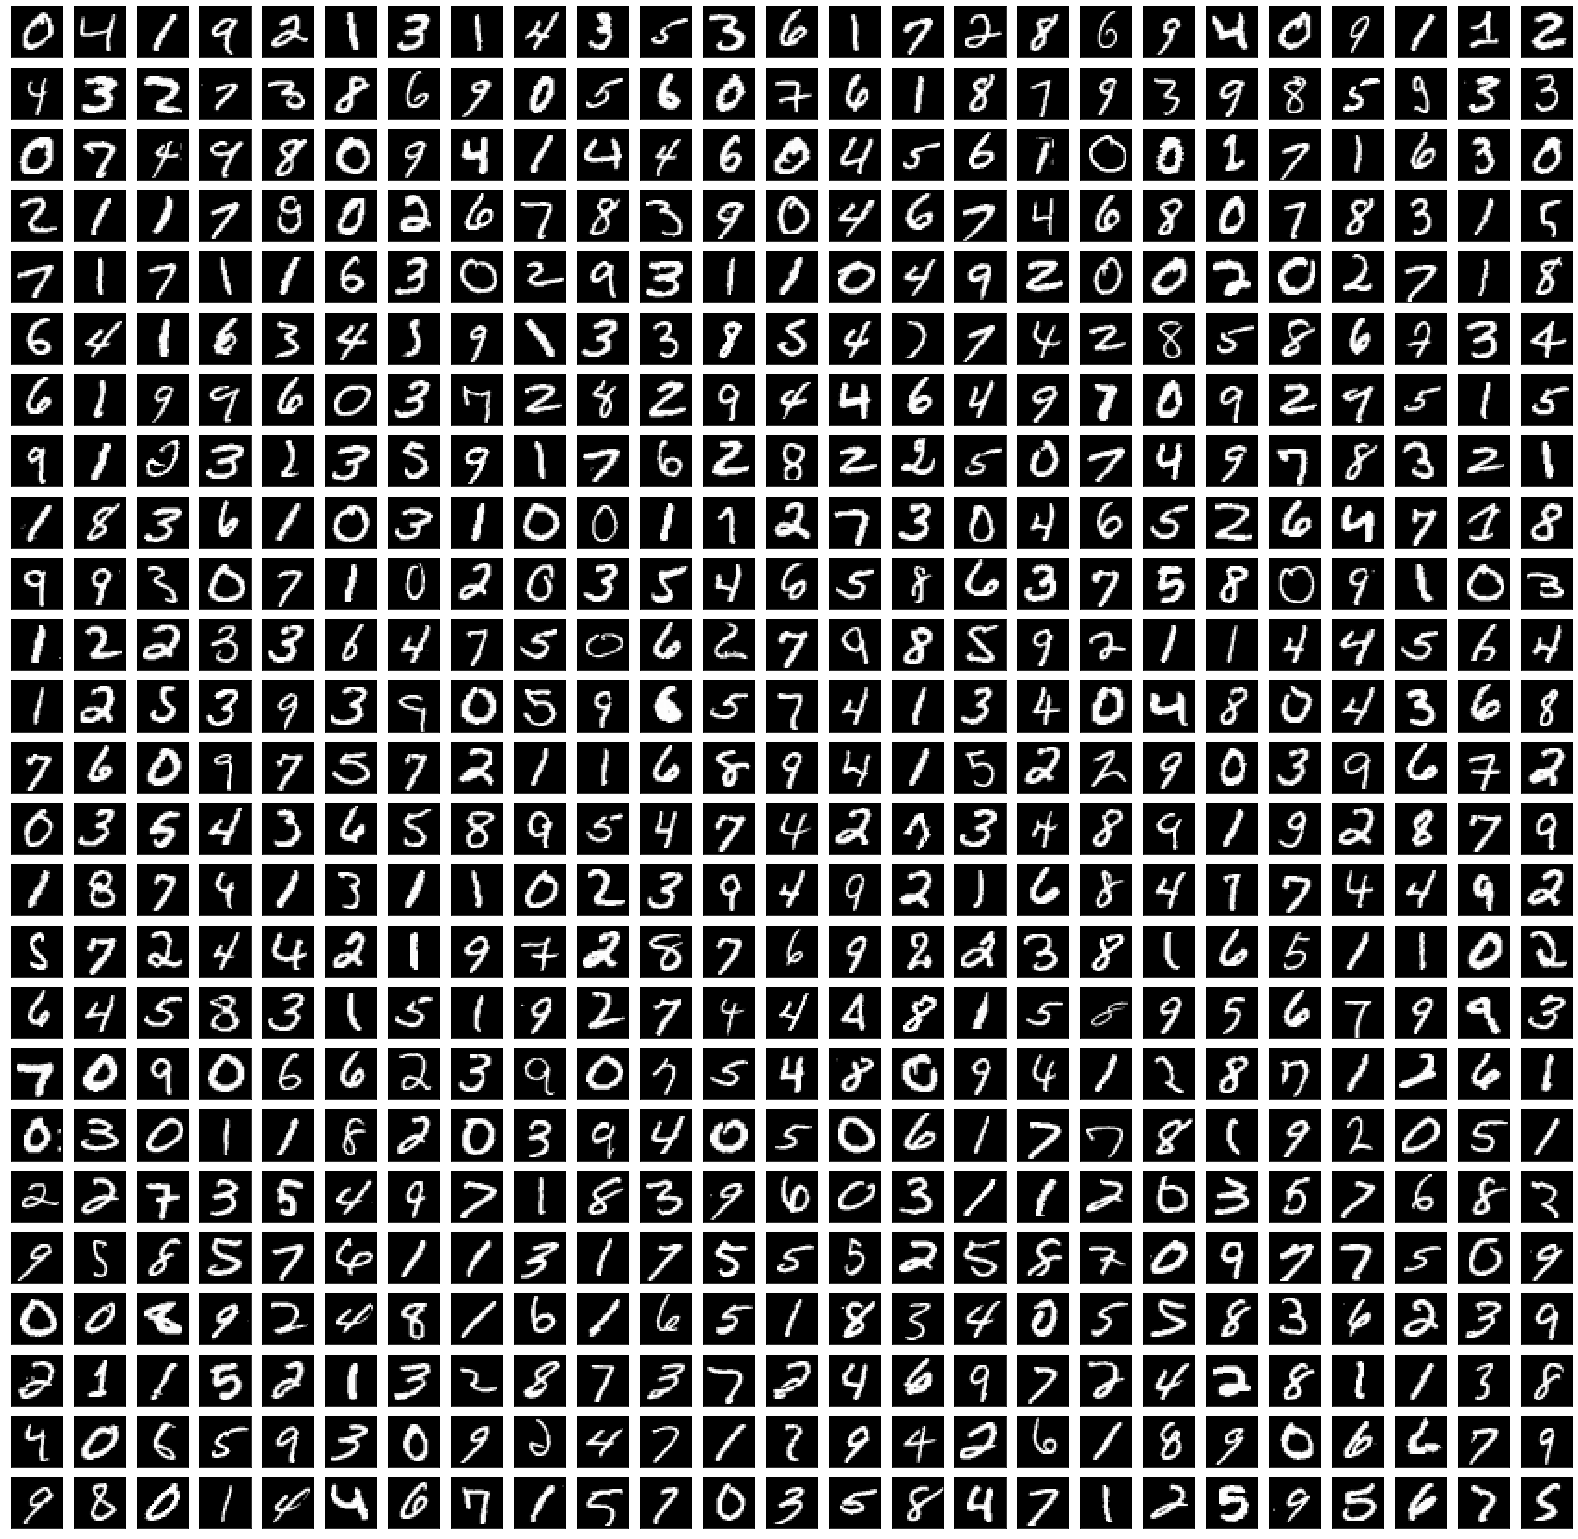

In [10]:
# Visualization of 25 x 25 original images of digits
fig = plt.figure(figsize=(28,28))
ind = 1
for i in range(1, 26, 1):
    for j in range(1, 26, 1):
        fig.add_subplot(25,25,ind)
        show(x_images[ind])
        plt.xticks([])
        plt.yticks([])
        ind+=1

### 5.3 Proposal for the autoencoder architecture

In [13]:
input_img = Input(shape=(784,))

encoded = Dense(512, activation='tanh')(input_img)
encoded = Dense(128, activation='tanh')(encoded)
encoded = Dense(32, activation='tanh')(encoded)

encoded = Dense(2)(encoded) # Linear activation function at the bottleneck

decoded = Dense(32, activation='tanh')(encoded)
decoded = Dense(128, activation='tanh')(decoded)
decoded = Dense(512, activation='tanh')(decoded)

decoded = Dense(784, activation = 'sigmoid')(decoded)

autoencoder = Model(input_img, decoded)

In [14]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_17 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_18 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 66        
_________________________________________________________________
dense_20 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_21 (Dense)             (None, 128)               4224  

In [16]:
autoencoder.compile(optimizer = "adam", loss = "mse")
X = x_train.reshape(x_train.shape[0], 784)
history = autoencoder.fit(X, X, batch_size = 128, epochs = 50, verbose = 1)

Epoch 1/50
469/469 [==============================] - 17s 5ms/step - loss: 0.0795
Epoch 2/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0487
Epoch 3/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0442
Epoch 4/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0422
Epoch 5/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0407
Epoch 6/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0397
Epoch 7/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0388
Epoch 8/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0383
Epoch 9/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0377
Epoch 10/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0374
Epoch 11/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0370
Epoch 12/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0366
Epoch 13/50
469/469 [===

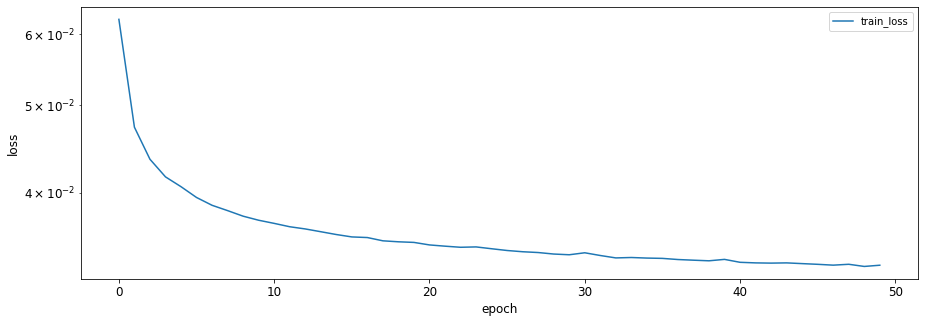

In [17]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

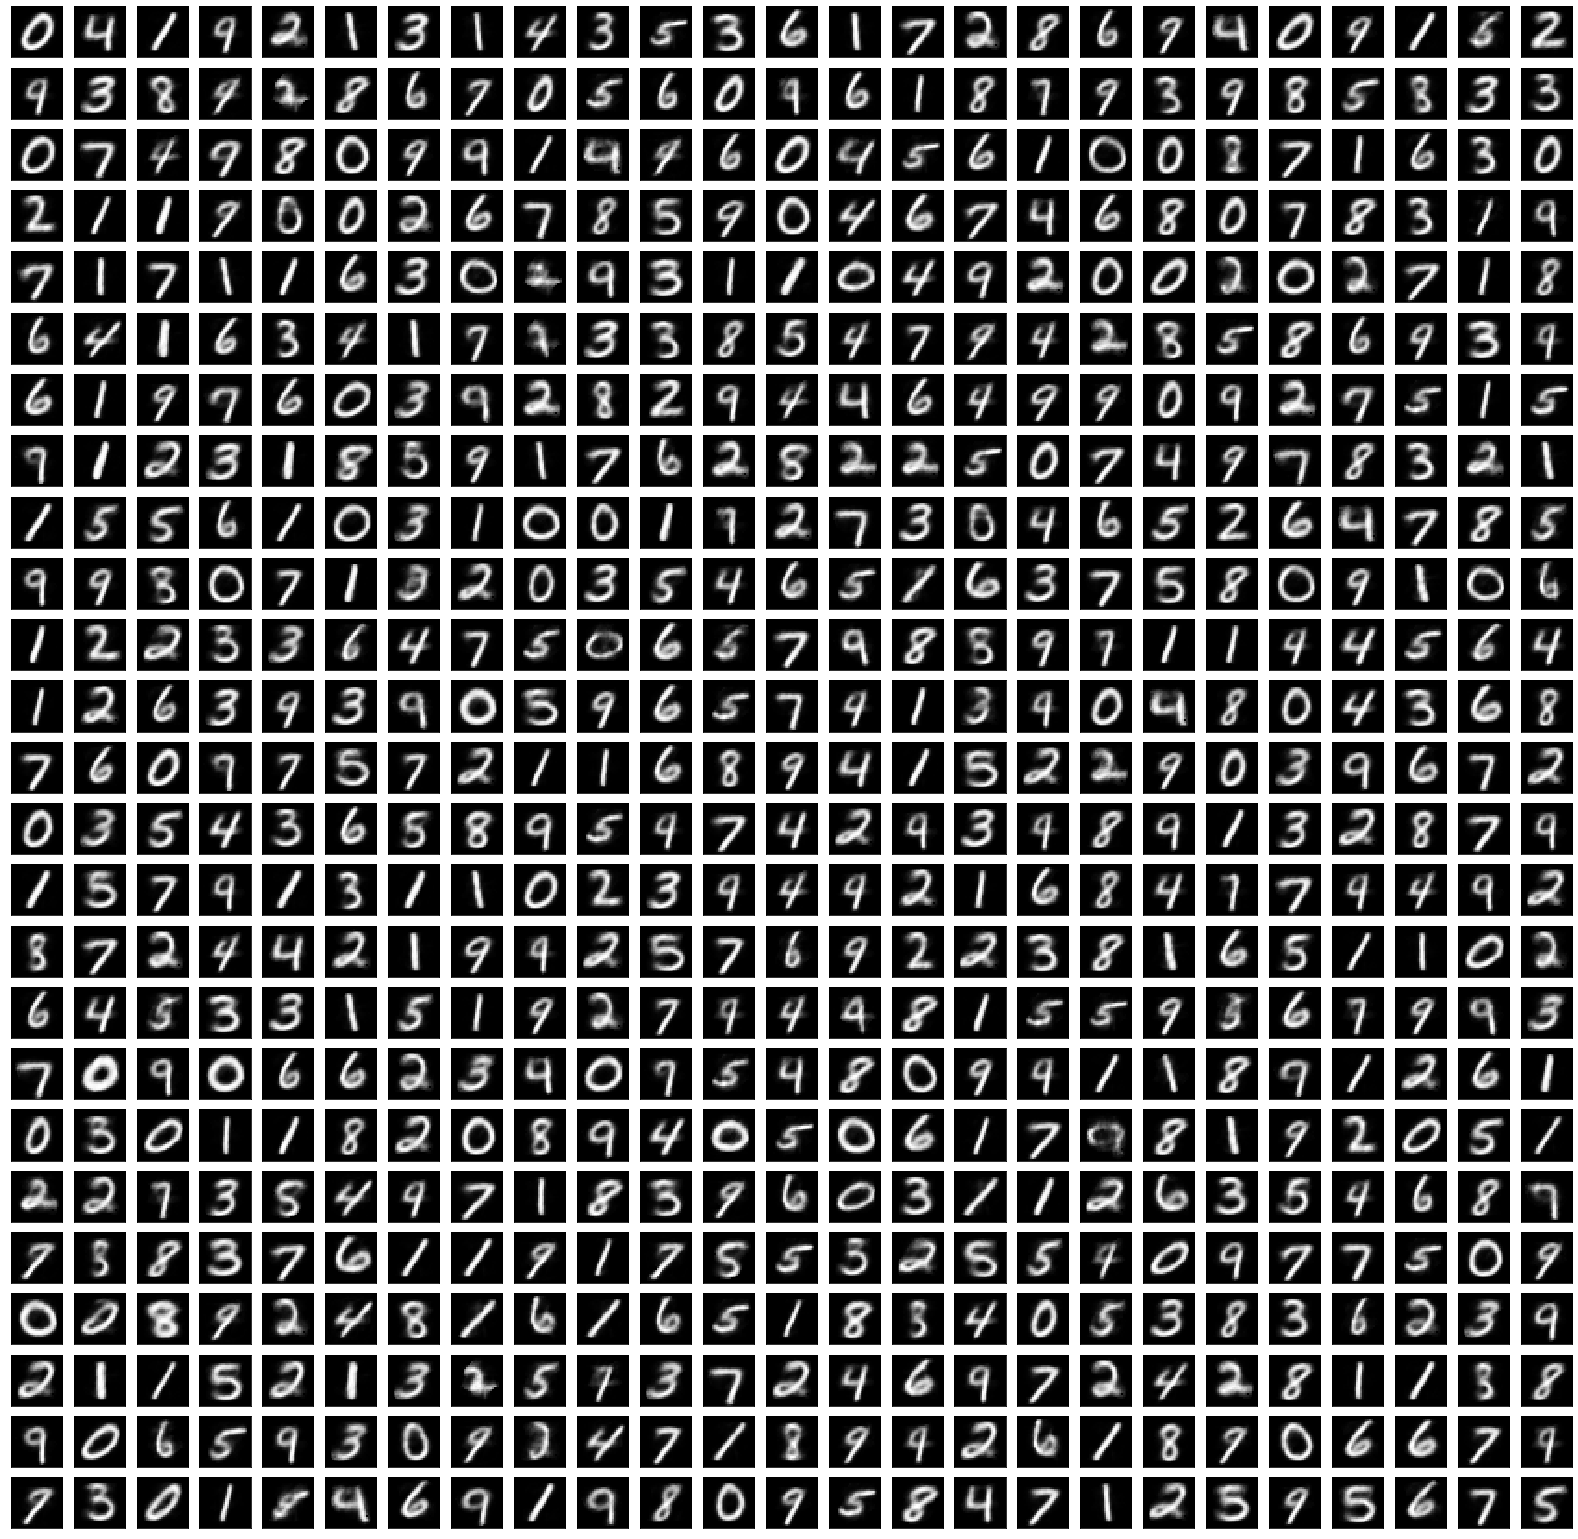

In [18]:
# Visualization of 25 x 25 reconstructed images of digits
fig = plt.figure(figsize=(28,28))
ind = 1
for i in range(1, 26, 1):
    for j in range(1, 26, 1):
        fig.add_subplot(25,25,ind)
        show(autoencoder.predict(np.expand_dims(x_images[ind].flatten(), 0)).reshape(28, 28))
        plt.xticks([])
        plt.yticks([])
        ind+=1

In [21]:
encoder = Model(input_img, encoded)

# Building the decoder
encoded_input = Input(shape=(2,))
encoded_layer_1 = autoencoder.layers[-4]
encoded_layer_2 = autoencoder.layers[-3]
encoded_layer_3 = autoencoder.layers[-2]
encoded_layer_4 = autoencoder.layers[-1]

decoder = encoded_layer_1(encoded_input)
decoder = encoded_layer_2(decoder)
decoder = encoded_layer_3(decoder)
decoder = encoded_layer_4(decoder)
decoder = Model(encoded_input, decoder)

### 5.4 Visualizing the mapping of the labeled images in the manifold

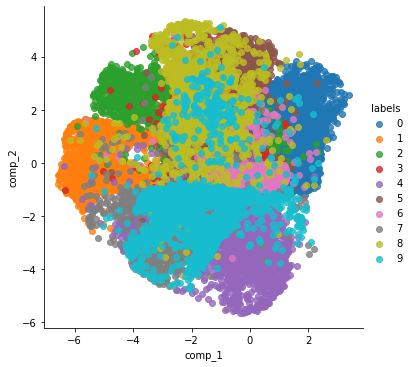

In [22]:
import seaborn as sns

x_flat = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])

x_proj = encoder.predict(x_flat[:60000])
x_proj.shape

proj = pd.DataFrame(x_proj)
proj.columns = ["comp_1", "comp_2"]
proj["labels"] = y_train[:60000]
sns.lmplot("comp_1", "comp_2", hue="labels", data=proj, fit_reg=False)

### 5.5. Generating new digits by moving along the manifold (latent 2D space)
**Please, adjust the scale whenever necessary.**

### 5.5.1 Moving along a circle

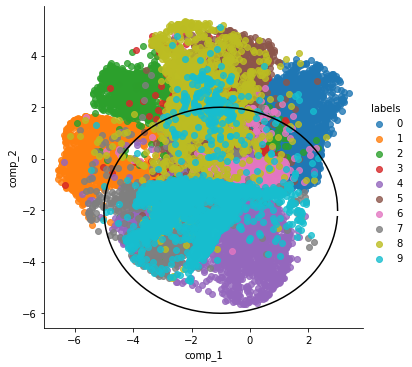

In [23]:
_ = sns.lmplot("comp_1", "comp_2", hue="labels", data=proj, fit_reg=False)
all_x = [4 * np.cos(2 * np.pi / 100 * i) - 1 for i in range(100)]
all_y = [4 * np.sin(2 * np.pi / 100 * i) - 2 for i in range(100)]
_ = plt.plot(all_x, all_y, 'black')

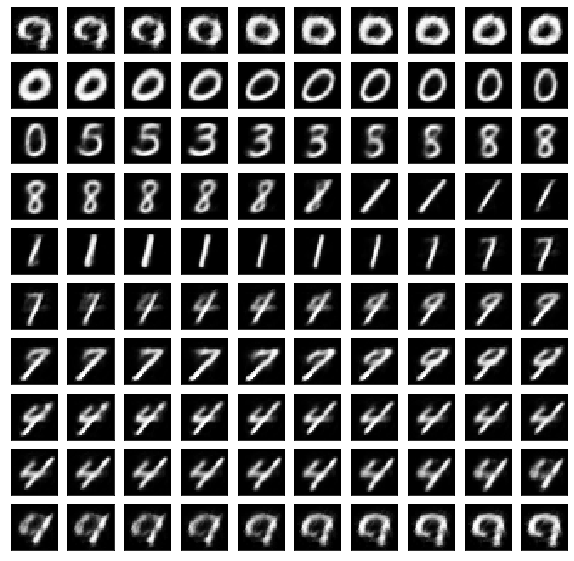

In [24]:
# moving along a circle:
_ = plt.figure(figsize=(10, 10))

for i in range(100):
    _ = plt.subplot(10, 10, i+1)
    
    x = 4 * np.cos(2 * np.pi / 100 * i) - 1
    y = 4 * np.sin(2 * np.pi / 100 * i) - 2
    
    pt = np.array([[x, y]])
    _ = show(decoder.predict(pt).reshape((28, 28)))
    _ = plt.xticks([])
    _ = plt.yticks([])

### 5.5.2 Moving along an ellipse

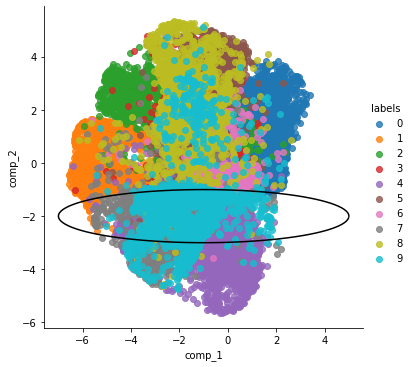

In [25]:
_ = sns.lmplot("comp_1", "comp_2", hue="labels", data=proj, fit_reg=False)
all_x = [6 * np.cos(2 * np.pi / 100 * i) - 1 for i in range(100)]
all_y = [1 * np.sin(2 * np.pi / 100 * i) - 2 for i in range(100)]
_ = plt.plot(all_x, all_y, 'black')

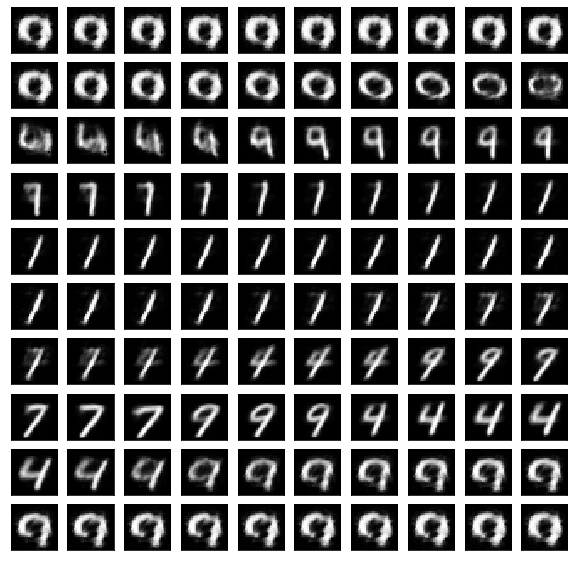

In [26]:
# moving along a elipse:
_ = plt.figure(figsize=(10, 10))

for i in range(100):
    _ = plt.subplot(10, 10, i+1)
    
    x = 6 * np.cos(2 * np.pi / 100 * i) - 1
    y = 1 * np.sin(2 * np.pi / 100 * i) - 2
    
    pt = np.array([[x, y]])
    _ = show(decoder.predict(pt).reshape((28, 28)))
    _ = plt.xticks([])
    _ = plt.yticks([])

### 5.5.3 Moving along a grid

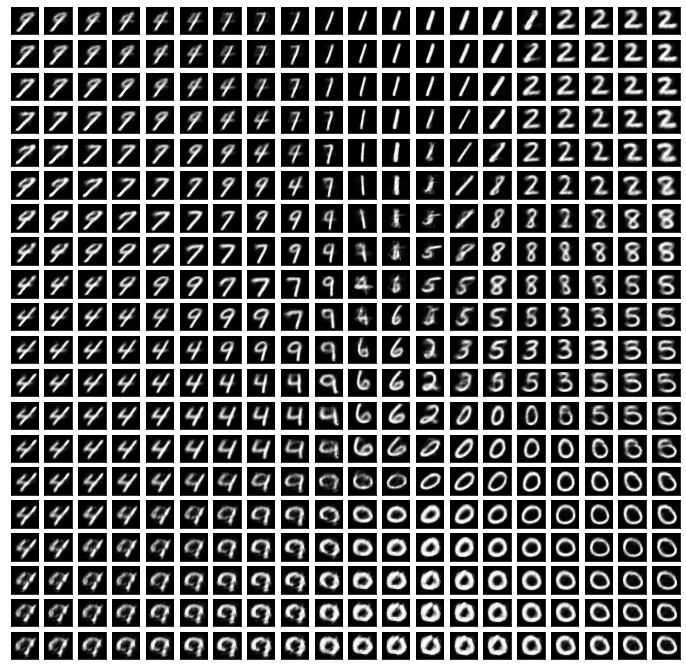

In [27]:
# moving along a elipse:
_ = plt.figure(figsize=(12, 12))

for i in range(20):
    for j in range(20):
        
        _ = plt.subplot(20, 20, i * 20 + j + 1)
        
        pt = np.array([[ -6 + 10 * i / 19, -6 + 10 * j / 19]])
        _ = show(decoder.predict(pt).reshape((28, 28)))
        _ = plt.xticks([])
        _ = plt.yticks([])